<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



## Desafio 2

- Alumno: Juan Miguel Chunga

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 47.6 MB/s eta 0:00:00


### Datos
Utilizaremos como dataset canciones de bandas de habla inglesa.

In [ ]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-12-08 07:07:23--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-12-08 07:07:23--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-12-08 07:07:23--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
# Posibles bandas
os.listdir("./songs_dataset/")

['leonard-cohen.txt',
 'nursery_rhymes.txt',
 'johnny-cash.txt',
 'rihanna.txt',
 'paul-simon.txt',
 'bob-marley.txt',
 'prince.txt',
 'kanye.txt',
 'Kanye_West.txt',
 'notorious-big.txt',
 'Lil_Wayne.txt',
 'janisjoplin.txt',
 'lil-wayne.txt',
 'alicia-keys.txt',
 'joni-mitchell.txt',
 'radiohead.txt',
 'bruce-springsteen.txt',
 'blink-182.txt',
 'nirvana.txt',
 'nicki-minaj.txt',
 'cake.txt',
 'jimi-hendrix.txt',
 'missy-elliott.txt',
 'michael-jackson.txt',
 'ludacris.txt',
 'notorious_big.txt',
 'beatles.txt',
 'dj-khaled.txt',
 'kanye-west.txt',
 'bruno-mars.txt',
 'britney-spears.txt',
 'drake.txt',
 'nickelback.txt',
 'adele.txt',
 'eminem.txt',
 'bieber.txt',
 'disney.txt',
 'lin-manuel-miranda.txt',
 'dr-seuss.txt',
 'lorde.txt',
 'r-kelly.txt',
 'bob-dylan.txt',
 'dickinson.txt',
 'al-green.txt',
 'dolly-parton.txt',
 'lady-gaga.txt',
 'bjork.txt',
 'amy-winehouse.txt',
 'patti-smith.txt']

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-3849064916.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


In [ ]:
# El documento hace referencia a las lineas de canciones de los beatles
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1846


### 1 - Preprocesamiento

In [ ]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo
sentence_tokens[:2]

[['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'],
 ['now', 'it', 'looks', 'as', 'though', "they're", 'here', 'to', 'stay']]

### 2 - Crear los vectores (word2vec)

In [ ]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 1846


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 445


### 3 - Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 113045.25
Loss after epoch 1: 65966.59375
Loss after epoch 2: 65934.984375
Loss after epoch 3: 65718.390625
Loss after epoch 4: 63875.09375
Loss after epoch 5: 64160.65625
Loss after epoch 6: 64080.21875
Loss after epoch 7: 64814.875
Loss after epoch 8: 62632.75
Loss after epoch 9: 60452.875
Loss after epoch 10: 59839.875
Loss after epoch 11: 58884.375
Loss after epoch 12: 57715.75
Loss after epoch 13: 56494.3125
Loss after epoch 14: 55817.5
Loss after epoch 15: 55842.9375
Loss after epoch 16: 51722.4375
Loss after epoch 17: 49858.0
Loss after epoch 18: 49592.25
Loss after epoch 19: 48960.125


(156986, 287740)

### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('pretty', 0.8954247832298279),
 ('sleep', 0.8665655851364136),
 ('help', 0.8439376354217529),
 ('cry', 0.8351269960403442),
 ('not', 0.8309612274169922),
 ('try', 0.8276943564414978),
 ('peace', 0.8144856691360474),
 ('little', 0.8140572309494019),
 ('twist', 0.8123919367790222),
 ('seems', 0.8079564571380615)]

In [ ]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)

[('shake', -0.22873197495937347),
 ('four', -0.2330218255519867),
 ('five', -0.23746445775032043),
 ('six', -0.23784494400024414),
 ('bang', -0.24832050502300262),
 ('our', -0.25539135932922363),
 ('day', -0.2689811885356903),
 ('going', -0.2692062556743622),
 ('here', -0.26990723609924316),
 ('three', -0.2838989198207855)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["four"], topn=10)

[('five', 0.9813723564147949),
 ('three', 0.9745770692825317),
 ('six', 0.9710808992385864),
 ('seven', 0.9584357738494873),
 ('two', 0.9517216682434082),
 ('sixty', 0.8990395665168762),
 ('one', 0.7951181530952454),
 ('crying', 0.7946289777755737),
 ('us', 0.7740051746368408),
 ("i'm", 0.7508383393287659)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["money"], topn=5)

[("can't", 0.9434017539024353),
 ('buy', 0.9396998882293701),
 ('much', 0.9033146500587463),
 ('just', 0.8509082198143005),
 ('hide', 0.835538387298584)]

In [ ]:
# Ensayar con una palabra que no está en el vocabulario:
# Nota, en clase se aclaro que no es posible que se use algo que no exista
# porque se esta aprendiendo en base a algo que se ha dado. Por lo tanto, palabras
# que no esten obtendran un error. Para mitigarlo y cumplir con lo indicado, se usa try-except.
try:
    w2v_model.wv.most_similar(negative=["diedaa"])
except KeyError:
    print("La palabra no está en el vocabulario.")

La palabra no está en el vocabulario.


In [ ]:
# el método `get_vector` permite obtener los vectores de la representacion numerica de una palabra:
vector_love = w2v_model.wv.get_vector("love")
print(vector_love)

[ 0.06138203  0.05881222 -0.06370417  0.02444947 -0.20152196 -0.18612292
 -0.15284595  0.4548753  -0.04217871  0.03536078  0.13657516 -0.18520005
 -0.1812647   0.22149836 -0.3038084  -0.23970386  0.07094695 -0.05679139
 -0.05166207 -0.23843557 -0.08530281  0.19564727 -0.07678778  0.03797247
  0.07517307 -0.04826551  0.07379535  0.10396848  0.00738022 -0.22764729
 -0.0456724   0.12937619  0.27785638  0.19387618 -0.13509148  0.20857106
  0.40917322 -0.00387122 -0.1063128  -0.09056759  0.02400028 -0.0800491
  0.13400665  0.08833536 -0.01894405  0.08592905 -0.15905626  0.10259357
  0.14459287 -0.12092585 -0.27919102 -0.04061577  0.11382084  0.31365854
 -0.07409792  0.13976744  0.22791271  0.13209458 -0.01811365  0.09772275
  0.09249583 -0.14871688 -0.16348091 -0.13203284 -0.09834065  0.02714608
  0.16531324  0.26051944 -0.0325964  -0.02894551  0.11621328 -0.06974234
  0.09563565 -0.15276384  0.22071053  0.15996666  0.1589048  -0.04711676
 -0.12555045 -0.03993924 -0.10795183  0.01878959  0.

In [ ]:
# el método `most_similar` también permite comparar a partir de vectores
# Aparentemente, no tiene mucha ventaja
w2v_model.wv.most_similar(vector_love)

[('love', 0.9999999403953552),
 ('babe', 0.9085132479667664),
 ('someone', 0.8886148929595947),
 ('need', 0.8827974200248718),
 ('nothing', 0.8740269541740417),
 ("didn't", 0.8638361096382141),
 ("there's", 0.8526672720909119),
 ('you', 0.8456704616546631),
 ('feed', 0.8445017337799072),
 ('somebody', 0.8362804651260376)]

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)

[('babe', 0.9085132479667664),
 ('someone', 0.8886148929595947),
 ('need', 0.8827974200248718),
 ('nothing', 0.8740269541740417),
 ("didn't", 0.8638360500335693),
 ("there's", 0.8526672720909119),
 ('you', 0.8456703424453735),
 ('feed', 0.8445016741752625),
 ('somebody', 0.8362804651260376),
 ('buy', 0.8351694941520691)]

### 5 - Visualizar agrupación de vectores

In [ ]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [ ]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [ ]:
# También se pueden guardar los vectores y labels como tsv para graficar en
# http://projector.tensorflow.org/


vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

### Consigna del desafío 2

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado**

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

## Desarrollo

Comenzamos seleccionando un artista del dataset provisto.

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (108 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree -sh songs_dataset

[4.0K]  songs_dataset
├── [ 89K]  adele.txt
├── [ 79K]  al-green.txt
├── [111K]  alicia-keys.txt
├── [ 75K]  amy-winehouse.txt
├── [ 69K]  beatles.txt
├── [140K]  bieber.txt
├── [ 52K]  bjork.txt
├── [ 95K]  blink-182.txt
├── [203K]  bob-dylan.txt
├── [ 89K]  bob-marley.txt
├── [132K]  britney-spears.txt
├── [105K]  bruce-springsteen.txt
├── [129K]  bruno-mars.txt
├── [ 76K]  cake.txt
├── [166K]  dickinson.txt
├── [ 86K]  disney.txt
├── [233K]  dj-khaled.txt
├── [ 86K]  dolly-parton.txt
├── [194K]  drake.txt
├── [ 30K]  dr-seuss.txt
├── [315K]  eminem.txt
├── [104K]  janisjoplin.txt
├── [ 70K]  jimi-hendrix.txt
├── [ 87K]  johnny-cash.txt
├── [ 99K]  joni-mitchell.txt
├── [150K]  kanye.txt
├── [251K]  kanye-west.txt
├── [251K]  Kanye_West.txt
├── [144K]  lady-gaga.txt
├── [ 97K]  leonard-cohen.txt
├── [115K]  lil-wayne.txt
├── [115K]  Lil_Wayne.txt
├── [ 57K]  lin-manuel-miranda.txt
├── [ 67K]  lorde.txt
├── [232K]  ludacris.txt
├── [251K]  michael-jackson.txt
├── [187K]  missy-elliott

Excluyendo a The Beatles, tenemos 48 opciones disponibles. Todos los archivos tienen tamaños variados, desde los 30 KB del archivo más ligero (dr-seuss.txt) hasta los 315 KB del más pesado (eminem.txt). Esta diversidad en tamaños sugiere diferencias significativas en la cantidad de contenido por artista, lo que puede influir en el procesamiento, análisis y carga de datos dentro del conjunto.

Además, hay que considerar que no necesariamente un tamaño mayor implica un contenido más útil. Un archivo puede ocupar más espacio simplemente porque incluye muchas líneas repetidas, variaciones mínimas entre versos o saltos de línea innecesarios que inflan el tamaño sin aportar información nueva. Del mismo modo, un archivo más pequeño puede contener contenido más compacto, limpio y relevante para el análisis.

Se selecciona a Bruno Mars para este experimento.

In [ ]:
# Lineas totales
!wc -l songs_dataset/bruno-mars.txt

3269 songs_dataset/bruno-mars.txt


In [ ]:
# Lineas vacias
!grep -c '^$' songs_dataset/bruno-mars.txt

0


Comparamos con otro artista, por ejemplo, Prince

In [ ]:
# Lineas totales
!wc -l songs_dataset/prince.txt

11749 songs_dataset/prince.txt


In [ ]:
# Lineas vacias
!grep -c '^$' songs_dataset/prince.txt

2133


El dataset de Prince pesa 306K, mientras que el de Bruno Mars pesa 129K. La cantidad de lineas con contenido es de 9616 y de 3269 respectivamente. En este caso, los pesos si reflejan cantidad de informacion. No obstante, se requiere un analisis mas profundo si se quiere verificar que las lineas realmente tienen variedad de contenido e informacion util.

Para fines del experimento, se continuará de esta manera.

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/bruno-mars.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-1259250787.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,0
0,Now greetings to the world! Standing at this l...
1,"Whiskey coming through my pores,"
2,Feeling like I run this whole block.
3,Lotto tickets cheap beer
4,"That's why you can catch me here,"


In [ ]:
# Deberia coincidir con el analisis anterior
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3270


In [ ]:
# Preprocesamiento
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [ ]:
# Demos un vistazo a las oraciones
sentence_tokens[:2]

[['now',
  'greetings',
  'to',
  'the',
  'world',
  'standing',
  'at',
  'this',
  'liquor',
  'store'],
 ['whiskey', 'coming', 'through', 'my', 'pores']]

### 2 - Crear los vectores (word2vec)

La clase callback ya ha sido creada. El w2v_model ha sido definido previamente, pero debe crearse nuevamente. Si el kernel se ha reiniciado, debe ejecutarse nuevamente todo el notebook.

In [ ]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [ ]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [ ]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 3270


In [ ]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 678


### 3 - Entrenar embeddings

In [ ]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 220947.59375
Loss after epoch 1: 143796.0
Loss after epoch 2: 141471.34375
Loss after epoch 3: 145462.875
Loss after epoch 4: 141509.0625
Loss after epoch 5: 136731.875
Loss after epoch 6: 128194.875
Loss after epoch 7: 110151.875
Loss after epoch 8: 106087.25
Loss after epoch 9: 104813.875
Loss after epoch 10: 101818.25
Loss after epoch 11: 99671.375
Loss after epoch 12: 98321.125
Loss after epoch 13: 96064.25
Loss after epoch 14: 95072.75
Loss after epoch 15: 94120.625
Loss after epoch 16: 93190.125
Loss after epoch 17: 88695.625
Loss after epoch 18: 84362.75
Loss after epoch 19: 83038.75


(328281, 538000)

### 4 - Ensayar

In [ ]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["darling"], topn=10)

[('getaway', 0.9448505640029907),
 ("should've", 0.7770295143127441),
 ('messed', 0.7765216827392578),
 ('silk', 0.7583726048469543),
 ('swear', 0.7460120320320129),
 ('block', 0.7430704236030579),
 ('roll', 0.7395370006561279),
 ('sheets', 0.7382366061210632),
 ('gave', 0.7380671501159668),
 ('behind', 0.7324386835098267)]

Se debe elegir términos de interés y buscar términos más similares y menos similares.

Se usó el ejemplo anterior con `darling`, el cual coincide por ser un artista ingles.

Es necesario definir algun criterio para seleccion de palabras.

In [ ]:
from operator import itemgetter
import nltk
from nltk.corpus import stopwords

# Descargar stopwords si no están descargadas
nltk.download('stopwords')

def top_frequent_words(w2v_model, top_n=20, min_len=3, remove_stopwords=True, language='english'):
    """
    Retorna las N palabras más frecuentes del vocabulario de un modelo Word2Vec,
    pudiendo filtrar palabras cortas y stopwords.

    Parámetros:
        w2v_model: modelo Word2Vec ya inicializado y con build_vocab ejecutado.
        top_n: cantidad de palabras a mostrar.
        min_len: longitud mínima requerida para incluir una palabra.
        remove_stopwords: si True, elimina stopwords del idioma seleccionado.
        language: idioma de las stopwords (por defecto inglés).
    """

    # Cargar stopwords si se desean eliminar
    stops = set(stopwords.words(language)) if remove_stopwords else set()

    # Extraer palabras y frecuencias con filtros
    frecuencias = [
        (word, w2v_model.wv.get_vecattr(word, "count"))
        for word in w2v_model.wv.index_to_key
        if len(word) >= min_len and word.lower() not in stops
    ]

    # Ordenar de mayor a menor frecuencia
    frecuencias_ordenadas = sorted(frecuencias, key=itemgetter(1), reverse=True)

    # Retornar las top N
    return frecuencias_ordenadas[:top_n]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Llamamos a la función
top_frequent_words(w2v_model, min_len=4)

[('yeah', np.int64(296)),
 ('like', np.int64(223)),
 ('know', np.int64(190)),
 ('baby', np.int64(168)),
 ('girl', np.int64(161)),
 ("'cause", np.int64(122)),
 ('take', np.int64(114)),
 ('love', np.int64(106)),
 ("that's", np.int64(100)),
 ('make', np.int64(90)),
 ('time', np.int64(86)),
 ('tell', np.int64(78)),
 ('long', np.int64(77)),
 ("can't", np.int64(75)),
 ('feel', np.int64(74)),
 ('come', np.int64(73)),
 ('night', np.int64(73)),
 ('wanna', np.int64(72)),
 ('never', np.int64(71)),
 ('show', np.int64(64))]

No se indica el minimo de terminos, por lo que se toman 5 para este proceso.

Las palabras seleccionadas son:
- time
- night
- feel
- love
- tell

In [ ]:
palabras_objetivo = ['time', 'night', 'feel', 'love', 'tell']

Ahora, buscamos los terminos mas y menos similares.

In [ ]:
def analizar_similitud(w2v_model, palabras, topn=10):
    """
    Para cada palabra en la lista, retorna:
      - sus palabras más similares (topn)
      - sus palabras menos similares (topn)

    Parámetros:
        w2v_model : modelo Word2Vec entrenado
        palabras  : lista de strings
        topn      : número de resultados a devolver en cada caso
    """

    resultados = {}

    for palabra in palabras:
        entry = {}

        if palabra not in w2v_model.wv:
            resultados[palabra] = "La palabra no existe en el vocabulario."
            continue

        # Más similares
        try:
            entry["mas_similares"] = w2v_model.wv.most_similar(
                positive=[palabra],
                topn=topn
            )
        except Exception as e:
            entry["mas_similares"] = f"Error: {e}"

        # Menos similares
        try:
            entry["menos_similares"] = w2v_model.wv.most_similar(
                negative=[palabra],
                topn=topn
            )
        except Exception as e:
            entry["menos_similares"] = f"Error: {e}"

        resultados[palabra] = entry

    return resultados

In [ ]:
def reporte_similitud_md(resultados):
    """
    Convierte el diccionario de resultados de similitud en un informe Markdown.

    resultados: dict con la estructura:
        {
          'palabra': {
              'mas_similares': [(word, score), ...],
              'menos_similares': [(word, score), ...]
          },
          ...
        }
    """

    md = "# Informe de similitud de palabras (Word2Vec)\n\n"

    for palabra, data in resultados.items():
        md += f"## Palabra objetivo: **{palabra}**\n\n"

        # Si la palabra tiene un error o no existe
        if isinstance(data, str):
            md += f"**Error:** {data}\n\n"
            continue

        # Tabla: más similares
        md += "### Palabras más similares\n\n"
        md += "| Palabra | Similitud |\n"
        md += "|---------|-----------|\n"
        for w, score in data["mas_similares"]:
            md += f"| {w} | {score:.4f} |\n"
        md += "\n"

        # Tabla: menos similares
        md += "### Palabras menos similares\n\n"
        md += "| Palabra | Similitud |\n"
        md += "|---------|-----------|\n"
        for w, score in data["menos_similares"]:
            md += f"| {w} | {score:.4f} |\n"
        md += "\n---\n\n"

    return md


In [ ]:
resultados = analizar_similitud(w2v_model, palabras_objetivo)

In [ ]:
reporte_similitud_md(resultados)

"# Informe de similitud de palabras (Word2Vec)\n\n## Palabra objetivo: **time**\n\n### Palabras más similares\n\n| Palabra | Similitud |\n|---------|-----------|\n| standing | 0.7527 |\n| last | 0.7281 |\n| morning | 0.7248 |\n| next | 0.7245 |\n| different | 0.7230 |\n| went | 0.7050 |\n| close | 0.7035 |\n| first | 0.7027 |\n| moonshine | 0.6945 |\n| ends | 0.6919 |\n\n### Palabras menos similares\n\n| Palabra | Similitud |\n|---------|-----------|\n| girls | -0.0817 |\n| here | -0.1491 |\n| around | -0.1572 |\n| ah | -0.1661 |\n| i'm | -0.1768 |\n| turn | -0.1922 |\n| four | -0.2104 |\n| pretty | -0.2117 |\n| we're | -0.2142 |\n| oo | -0.2153 |\n\n---\n\n## Palabra objetivo: **night**\n\n### Palabras más similares\n\n| Palabra | Similitud |\n|---------|-----------|\n| another | 0.7240 |\n| call | 0.7132 |\n| lookin' | 0.7085 |\n| bar | 0.7077 |\n| about | 0.7034 |\n| their | 0.6899 |\n| waitin' | 0.6781 |\n| taking | 0.6706 |\n| late | 0.6694 |\n| away | 0.6632 |\n\n### Palabras men

# Informe de similitud de palabras (Word2Vec)

## Palabra objetivo: **time**

### Palabras más similares

| Palabra | Similitud |
|---------|-----------|
| standing | 0.7527 |
| last | 0.7281 |
| morning | 0.7248 |
| next | 0.7245 |
| different | 0.7230 |
| went | 0.7050 |
| close | 0.7035 |
| first | 0.7027 |
| moonshine | 0.6945 |
| ends | 0.6919 |

### Palabras menos similares

| Palabra | Similitud |
|---------|-----------|
| girls | -0.0817 |
| here | -0.1491 |
| around | -0.1572 |
| ah | -0.1661 |
| i'm | -0.1768 |
| turn | -0.1922 |
| four | -0.2104 |
| pretty | -0.2117 |
| we're | -0.2142 |
| oo | -0.2153 |

---

## Palabra objetivo: **night**

### Palabras más similares

| Palabra | Similitud |
|---------|-----------|
| another | 0.7240 |
| call | 0.7132 |
| lookin' | 0.7085 |
| bar | 0.7077 |
| about | 0.7034 |
| their | 0.6899 |
| waitin' | 0.6781 |
| taking | 0.6706 |
| late | 0.6694 |
| away | 0.6632 |

### Palabras menos similares

| Palabra | Similitud |
|---------|-----------|
| getaway | -0.1295 |
| try | -0.1553 |
| que | -0.1556 |
| today | -0.1774 |
| mi | -0.1777 |
| da | -0.1810 |
| messed | -0.1844 |
| en | -0.1854 |
| y | -0.1856 |
| para | -0.1871 |

---

## Palabra objetivo: **feel**

### Palabras más similares

| Palabra | Similitud |
|---------|-----------|
| warmin' | 0.7752 |
| i've | 0.7405 |
| hours | 0.7310 |
| mean | 0.7246 |
| shine | 0.7111 |
| mess | 0.7101 |
| use | 0.6986 |
| broken | 0.6957 |
| cause | 0.6887 |
| move | 0.6883 |

### Palabras menos similares

| Palabra | Similitud |
|---------|-----------|
| ya | -0.1627 |
| stops | -0.1703 |
| other | -0.1796 |
| stares | -0.1831 |
| tomorrow | -0.1844 |
| i'll | -0.1894 |
| coming | -0.1950 |
| home | -0.1985 |
| store | -0.2023 |
| standing | -0.2030 |

---

## Palabra objetivo: **love**

### Palabras más similares

| Palabra | Similitud |
|---------|-----------|
| gorillas | 0.6914 |
| madly | 0.6776 |
| yes | 0.6495 |
| promise | 0.6488 |
| faith | 0.6485 |
| his | 0.6349 |
| makes | 0.6305 |
| had | 0.6283 |
| seems | 0.6278 |
| wanted | 0.6145 |

### Palabras menos similares

| Palabra | Similitud |
|---------|-----------|
| girls | -0.1581 |
| straight | -0.1627 |
| getaway | -0.1653 |
| estamos | -0.1687 |
| so | -0.1715 |
| en | -0.1724 |
| side | -0.1875 |
| atrapados | -0.1909 |
| to | -0.1945 |
| esto | -0.2041 |

---

## Palabra objetivo: **tell**

### Palabras más similares

| Palabra | Similitud |
|---------|-----------|
| cares | 0.7790 |
| didn't | 0.7519 |
| please | 0.7507 |
| truth | 0.7423 |
| who | 0.7277 |
| crazy | 0.7235 |
| everyday | 0.7234 |
| die | 0.7111 |
| catch | 0.7032 |
| remember | 0.7024 |

### Palabras menos similares

| Palabra | Similitud |
|---------|-----------|
| life | -0.1483 |
| babe | -0.1494 |
| control | -0.1521 |
| our | -0.1577 |
| good | -0.1670 |
| brand | -0.1688 |
| up | -0.1797 |
| today | -0.1821 |
| alright | -0.1995 |
| voices | -0.2140 |

---



Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.

In [ ]:
# Graficar en 2D
vecs, labels = reduce_dimensions(w2v_model) #Reduccion a 2 dimensiones

# Graficar embeddings
MAX_WORDS=150 #200 es el valor por defecto. Al iterar varias veces,
# el valor de 250 muestra mucha información, pero el valor de 150 muestra
# adecuadamente los puntos. Es necesario usar el cursor para ver el texto
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.update_traces(
    textposition="bottom center",textfont=dict(size=9),
    marker=dict(opacity=0.7,size=3,color="blue")
)
fig.show(renderer="colab") # esto para plotly en colab

Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

## Conjunto de datos en español

Se observa una sección con terminos en español, pero las canciones de bruno mars no incluye terminos de este tipo. Puede tratarse de un problema con el dataset.

Al investigarse un poco, se encontro una canción escrita por Bruno Mars que es“Long Distance” – Bruno Mars (demo / unreleased original). Sin embargo, esta fue vendida y posteriormente interpretada por otro artista como “[Long Distance – Brandy](https://www.letras.com/brandy/1365734/)”.

Aparentemente, parte de esta canción se traduce y llega a formar fragmentos mostrados, lo cual tiene sentido. Pero se recalca que debe hacerse un analisis mas profundo para confirmar o desmentir este supuesto.

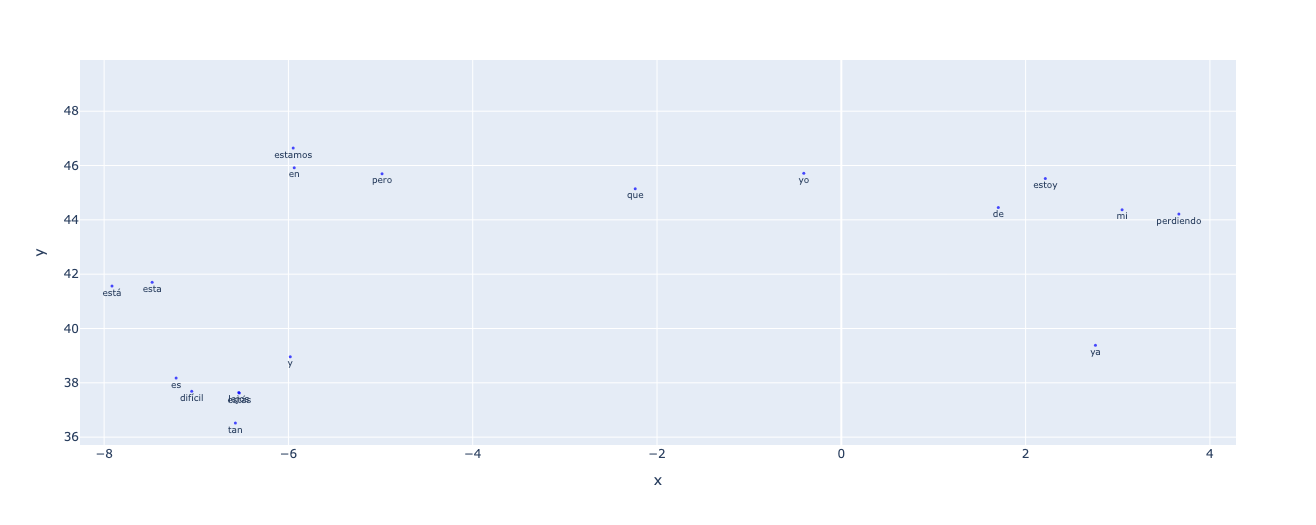

## Uptown funk

Los terminos mostrados coinciden en su mayoria por la canción del artista.

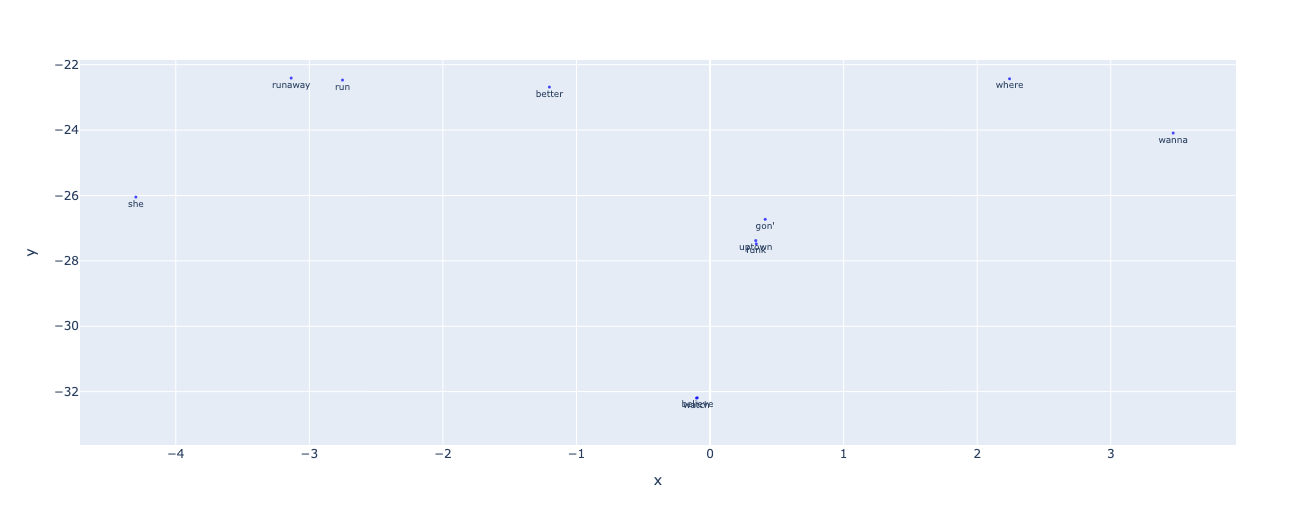

## More today than yesterday

Se repite el patron de coincidencia por canción.

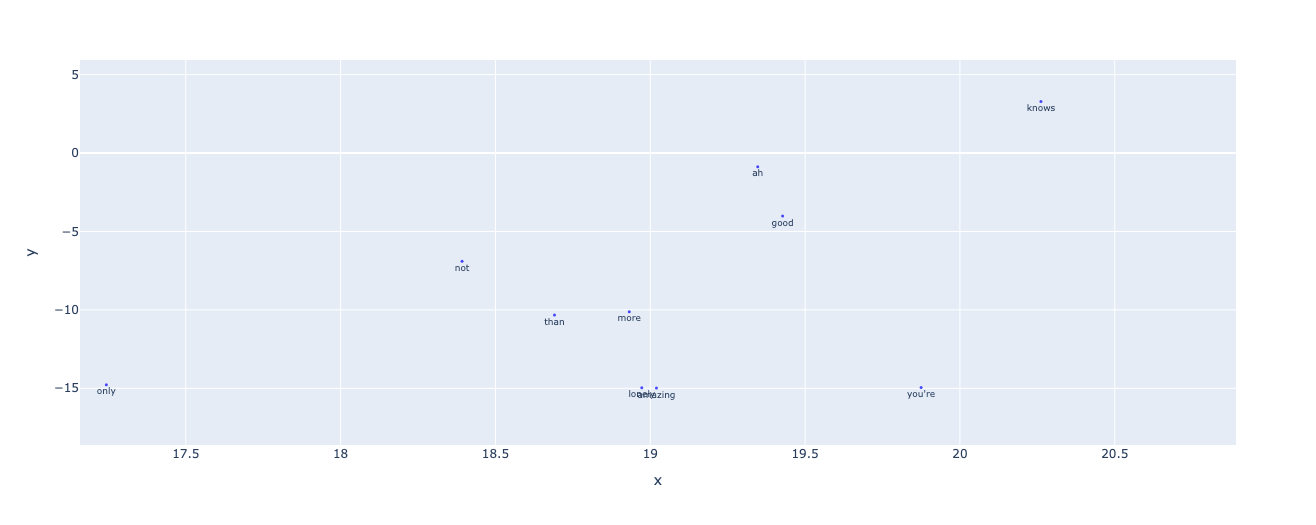

## Locked out of heaven

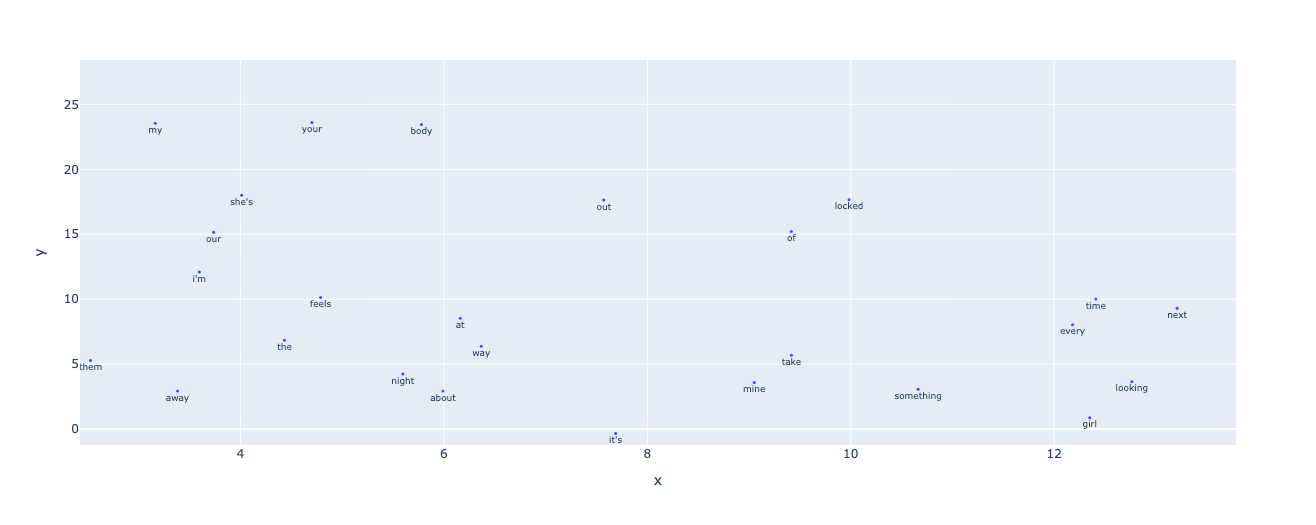

Runaway baby

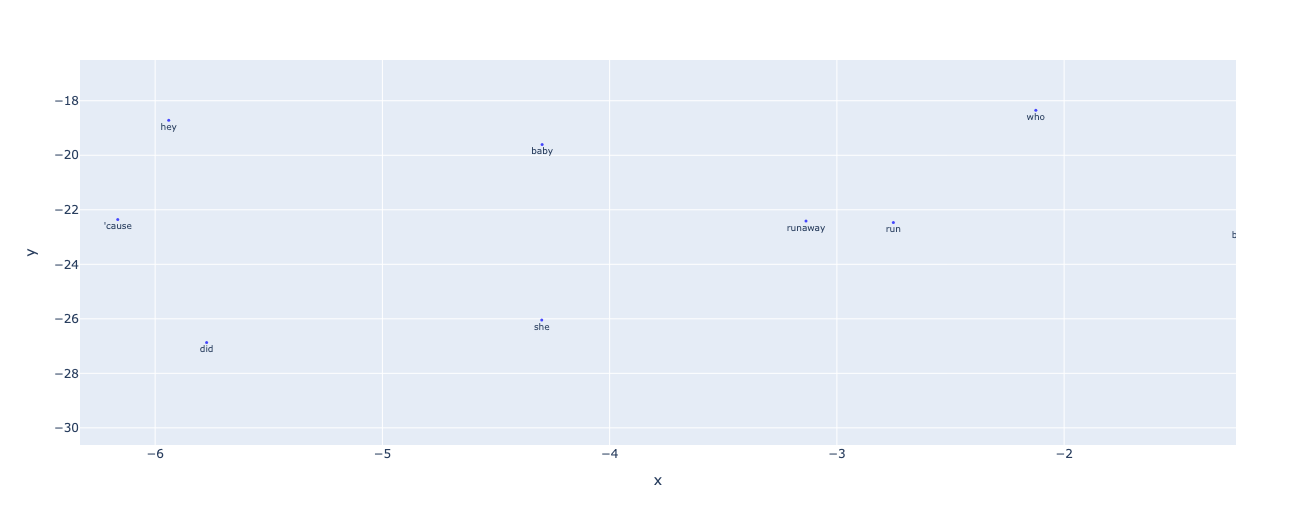

## Conclusiones del experimento

- El corpus fue tratado para eliminar palabras comunes en ingles, ademas de eliminar palabras muy cortas para evitar terminos irrelevantes.

- Al observar la representación en dos dimensiones, se identifican similitudes de idioma y por canciones.

- Una sección tiene terminos en español, lo cual da a entender que son parte de una misma canción, pero es necesario hacer un análisis más profundo.